$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [115]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw4/answers.py`.

In [116]:
import cs3600.plot as plot
import cs3600.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs3600.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\nitsa\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\nitsa\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\nitsa\.pytorch-datasets\lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [117]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


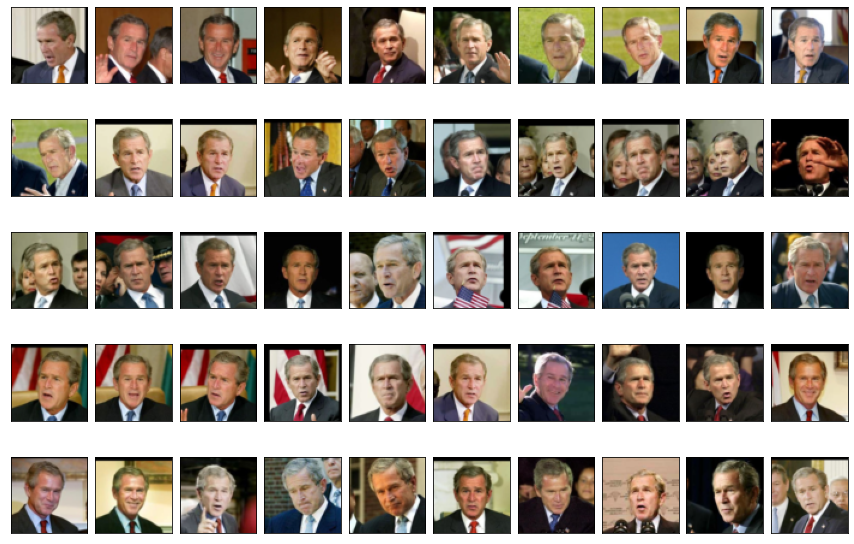

In [118]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [119]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw4/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [120]:
import hw4.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(1024, 1, k

**TODO**: Implement the `Generator` class in the `hw4/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [121]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
t

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw4/gan.py` module.

In [122]:
from hw4.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw4/gan.py` module.

In [ ]:
from hw4.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw4/gan.py` module.

In [ ]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw4/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw4/answers.py` module.

In [148]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw4.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 10, 'z_dim': 100, 'data_label': 0, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999), 'weight_decay': 0.001}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999), 'weight_decay': 0.001}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw4.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.95it/s]
Discriminator loss: 0.3492261476041573
Generator loss:     14.213211059570312


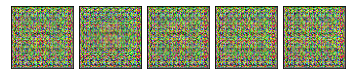

--- EPOCH 2/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.44it/s]
Discriminator loss: 0.3388858690225291
Generator loss:     18.60680363313207


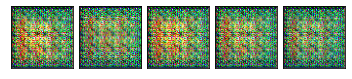

--- EPOCH 3/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.44it/s]
Discriminator loss: 0.20696357236999385
Generator loss:     10.449723774532103
saved model at epoch number 3 !
Saved checkpoint.


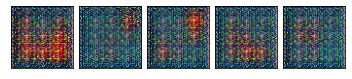

--- EPOCH 4/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.28592732257016423
Generator loss:     8.659720254394243
saved model at epoch number 4 !
Saved checkpoint.


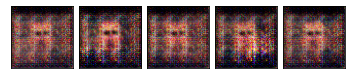

--- EPOCH 5/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.6363174239841273
Generator loss:     5.352314579037
saved model at epoch number 5 !
Saved checkpoint.


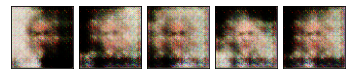

--- EPOCH 6/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.30it/s]
Discriminator loss: 0.5742325226618152
Generator loss:     5.300567604460806
saved model at epoch number 6 !
Saved checkpoint.


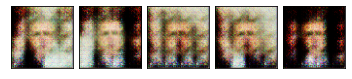

--- EPOCH 7/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.35it/s]
Discriminator loss: 0.5514069150360126
Generator loss:     6.313412360425265


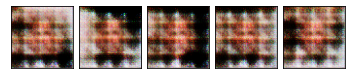

--- EPOCH 8/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.26it/s]
Discriminator loss: 0.49938215076361064
Generator loss:     5.9859818332600145


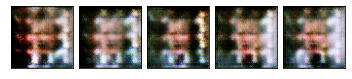

--- EPOCH 9/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.27it/s]
Discriminator loss: 0.6799286131588917
Generator loss:     5.810567554437889


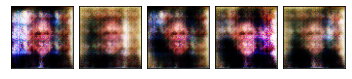

--- EPOCH 10/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]
Discriminator loss: 0.5743207674965544
Generator loss:     5.809519560831897


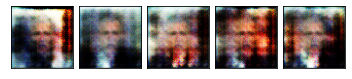

--- EPOCH 11/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.5699511994871328
Generator loss:     5.105407226760432
saved model at epoch number 11 !
Saved checkpoint.


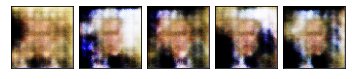

--- EPOCH 12/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.6015507462170889
Generator loss:     5.4570607374299245


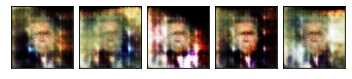

--- EPOCH 13/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]
Discriminator loss: 0.6258699220587622
Generator loss:     5.0359504717700885
saved model at epoch number 13 !
Saved checkpoint.


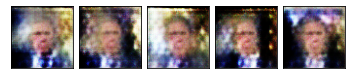

--- EPOCH 14/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]
Discriminator loss: 0.6142128287058957
Generator loss:     5.303912152659218


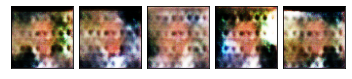

--- EPOCH 15/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.6121193585249612
Generator loss:     5.418446396881679


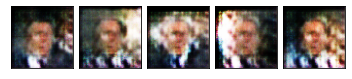

--- EPOCH 16/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]
Discriminator loss: 0.6490696970865412
Generator loss:     5.947621826855642


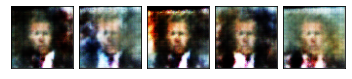

--- EPOCH 17/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]
Discriminator loss: 0.4917955447761518
Generator loss:     5.675946761976998


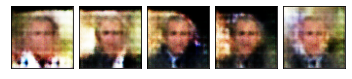

--- EPOCH 18/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.40it/s]
Discriminator loss: 0.5421212325751219
Generator loss:     5.822701508144163


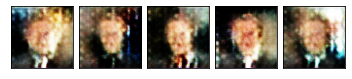

--- EPOCH 19/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.4651981878955409
Generator loss:     5.181436584805542


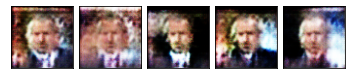

--- EPOCH 20/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.43it/s]
Discriminator loss: 0.5141126021110224
Generator loss:     5.926922820649057


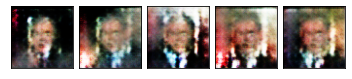

--- EPOCH 21/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.38it/s]
Discriminator loss: 0.44094961846493325
Generator loss:     5.663538111830658


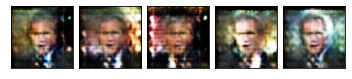

--- EPOCH 22/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.44it/s]
Discriminator loss: 0.44233065105552943
Generator loss:     6.091118781071789


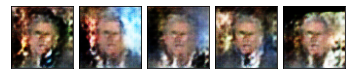

--- EPOCH 23/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.43it/s]
Discriminator loss: 0.4176006971524571
Generator loss:     5.638878716612762


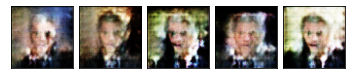

--- EPOCH 24/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.40it/s]
Discriminator loss: 0.6177973670638958
Generator loss:     6.188146744134291


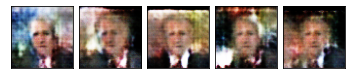

--- EPOCH 25/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.40410602679651864
Generator loss:     5.887215789758934


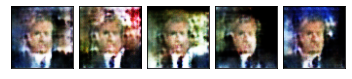

--- EPOCH 26/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.43it/s]
Discriminator loss: 0.4455428750447507
Generator loss:     6.0652374051651865


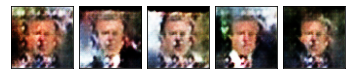

--- EPOCH 27/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.48992551061904654
Generator loss:     5.606663400272153


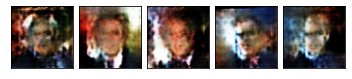

--- EPOCH 28/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.18it/s]
Discriminator loss: 0.41003877890981594
Generator loss:     5.722306591159892


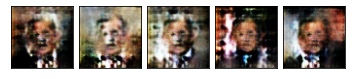

--- EPOCH 29/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.21it/s]
Discriminator loss: 0.39064597331409184
Generator loss:     5.872322253461154


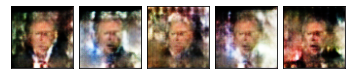

--- EPOCH 30/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.16it/s]
Discriminator loss: 0.3514349625076888
Generator loss:     6.050661084786901


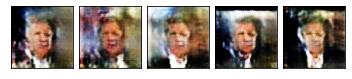

--- EPOCH 31/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.34it/s]
Discriminator loss: 0.3615307755205991
Generator loss:     5.772600700270455


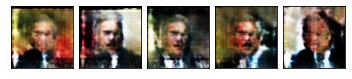

--- EPOCH 32/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.29it/s]
Discriminator loss: 0.3937338783915313
Generator loss:     6.0060007212296975


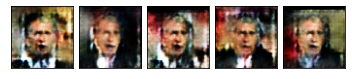

--- EPOCH 33/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.36it/s]
Discriminator loss: 0.3386515403553
Generator loss:     6.051937903998033


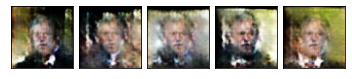

--- EPOCH 34/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.29612101851698924
Generator loss:     6.255210386132294


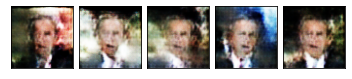

--- EPOCH 35/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.36it/s]
Discriminator loss: 0.2492993599120176
Generator loss:     6.366672088515084


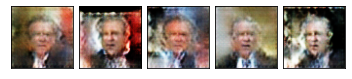

--- EPOCH 36/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.26214313204839546
Generator loss:     6.294168247366851


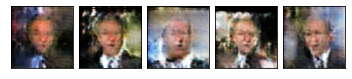

--- EPOCH 37/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.44it/s]
Discriminator loss: 0.34214820617915326
Generator loss:     6.847512636544569


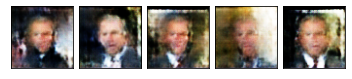

--- EPOCH 38/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.44it/s]
Discriminator loss: 0.4274204514991
Generator loss:     6.547820941457209


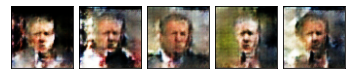

--- EPOCH 39/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.35176565782782043
Generator loss:     6.140997351340528


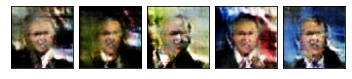

--- EPOCH 40/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.27it/s]
Discriminator loss: 0.2901762628330375
Generator loss:     6.051032019111346


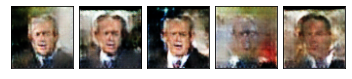

--- EPOCH 41/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.40it/s]
Discriminator loss: 0.2073407484183334
Generator loss:     6.045219270688183


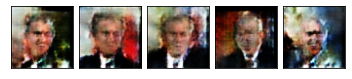

--- EPOCH 42/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.13it/s]
Discriminator loss: 0.44057364789944775
Generator loss:     7.196775937980076


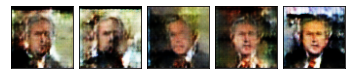

--- EPOCH 43/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]
Discriminator loss: 0.38183111820440246
Generator loss:     6.313989322140531


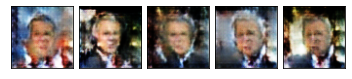

--- EPOCH 44/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.34714950266171174
Generator loss:     6.309003987402286


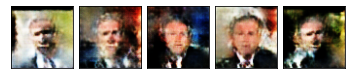

--- EPOCH 45/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.2272803360982886
Generator loss:     5.630985138551244


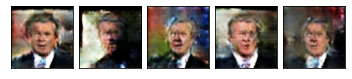

--- EPOCH 46/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.31680880690801816
Generator loss:     6.744950193279195


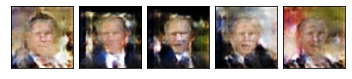

--- EPOCH 47/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.38it/s]
Discriminator loss: 0.28488986935677396
Generator loss:     6.367613790170202


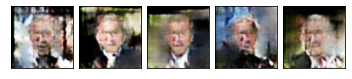

--- EPOCH 48/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.12it/s]
Discriminator loss: 0.30863546643335865
Generator loss:     6.684013231745306


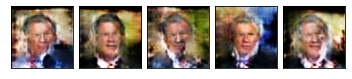

--- EPOCH 49/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.23it/s]
Discriminator loss: 0.27500797196660404
Generator loss:     6.670524223795477


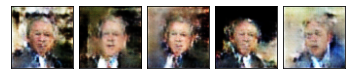

--- EPOCH 50/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.16it/s]
Discriminator loss: 0.2160781702764754
Generator loss:     6.6648460829033045


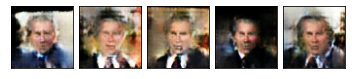

--- EPOCH 51/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.37it/s]
Discriminator loss: 0.3036454125254784
Generator loss:     7.399475228111699


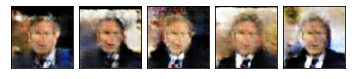

--- EPOCH 52/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.85it/s]
Discriminator loss: 0.2873574994451735
Generator loss:     5.932492260663015


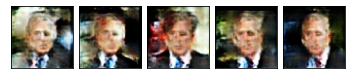

--- EPOCH 53/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.20714054954290953
Generator loss:     6.803567193589121


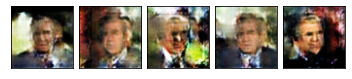

--- EPOCH 54/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]
Discriminator loss: 0.2934855334109293
Generator loss:     6.306115901695107


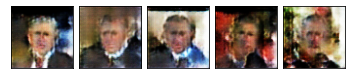

--- EPOCH 55/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.43it/s]
Discriminator loss: 0.2377858910498754
Generator loss:     6.079917655800873


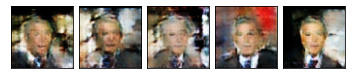

--- EPOCH 56/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.44it/s]
Discriminator loss: 0.12109223950021672
Generator loss:     5.870189284378627


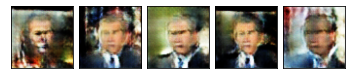

--- EPOCH 57/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.44it/s]
Discriminator loss: 0.318820353799482
Generator loss:     7.258268612735677


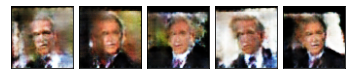

--- EPOCH 58/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.44it/s]
Discriminator loss: 0.2407197581850133
Generator loss:     6.496784133731194


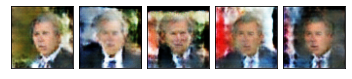

--- EPOCH 59/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.48it/s]
Discriminator loss: 0.30238048690107633
Generator loss:     6.890773723710258


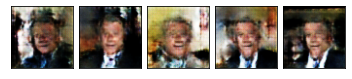

--- EPOCH 60/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.26394959166646004
Generator loss:     6.991441920118512


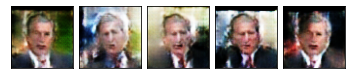

--- EPOCH 61/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.2531385749473043
Generator loss:     6.83646119090746


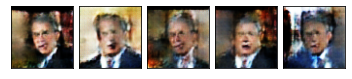

--- EPOCH 62/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.15473731642342964
Generator loss:     6.496768560049669


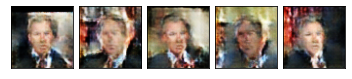

--- EPOCH 63/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.15025316565385405
Generator loss:     6.957902444983429


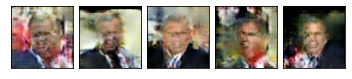

--- EPOCH 64/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]
Discriminator loss: 0.08965285034533942
Generator loss:     6.9687421366853535


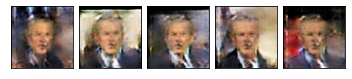

--- EPOCH 65/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.11743986154994313
Generator loss:     7.784741550121668


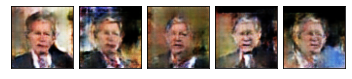

--- EPOCH 66/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.43it/s]
Discriminator loss: 0.1649521562130243
Generator loss:     7.834680813663411


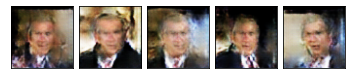

--- EPOCH 67/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.32447151871362945
Generator loss:     8.585803052164474


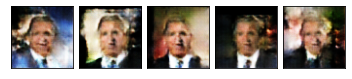

--- EPOCH 68/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]
Discriminator loss: 0.5100983668399869
Generator loss:     7.670980532214327


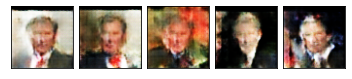

--- EPOCH 69/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.73it/s]
Discriminator loss: 0.2881530449145807
Generator loss:     6.596179602281103


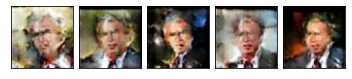

--- EPOCH 70/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.43it/s]
Discriminator loss: 0.17955024472881495
Generator loss:     6.244660386499369


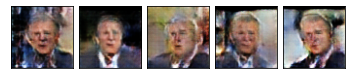

--- EPOCH 71/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.46it/s]
Discriminator loss: 0.20058721753786196
Generator loss:     6.899998502911262


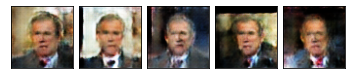

--- EPOCH 72/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.15356582498292104
Generator loss:     6.497382942235695


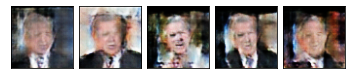

--- EPOCH 73/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.35488501857122723
Generator loss:     7.01319275487144


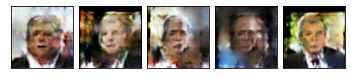

--- EPOCH 74/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.1073678319852026
Generator loss:     6.155364436923333


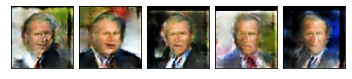

--- EPOCH 75/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.44it/s]
Discriminator loss: 0.11826311198572786
Generator loss:     7.002151082146843


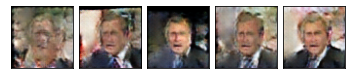

--- EPOCH 76/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.41it/s]
Discriminator loss: 0.1465544854378644
Generator loss:     7.446211419015561


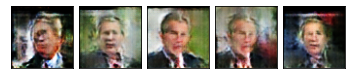

--- EPOCH 77/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.12897047976840217
Generator loss:     6.988480590424448


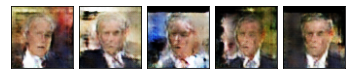

--- EPOCH 78/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]
Discriminator loss: 0.0888103593211129
Generator loss:     6.593292863863819


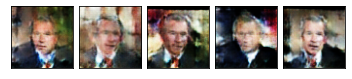

--- EPOCH 79/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.09345564567747544
Generator loss:     7.359342826987213


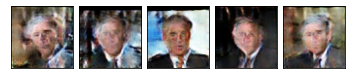

--- EPOCH 80/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.42it/s]
Discriminator loss: 0.3486144531272211
Generator loss:     9.655347207807145


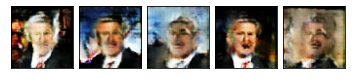

--- EPOCH 81/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.43it/s]
Discriminator loss: 0.21102022140655877
Generator loss:     7.2637624763092905


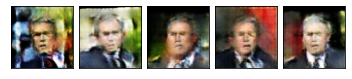

--- EPOCH 82/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.69it/s]
Discriminator loss: 0.3407696617661782
Generator loss:     7.38991982082151


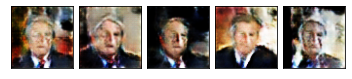

--- EPOCH 83/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.08it/s]
Discriminator loss: 0.22700952735009058
Generator loss:     7.4865248563154685


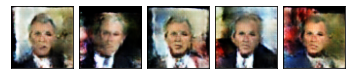

--- EPOCH 84/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.01it/s]
Discriminator loss: 0.19863039402748053
Generator loss:     7.052189696509883


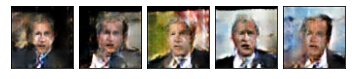

--- EPOCH 85/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.07it/s]
Discriminator loss: 0.13429345677272891
Generator loss:     6.919587252274999


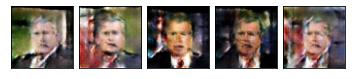

--- EPOCH 86/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.68it/s]
Discriminator loss: 0.18788520756335753
Generator loss:     7.680828782747376


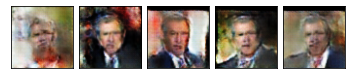

--- EPOCH 87/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.27it/s]
Discriminator loss: 0.18641460606090302
Generator loss:     7.449327936712301


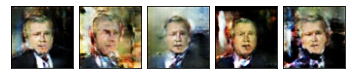

--- EPOCH 88/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.77it/s]
Discriminator loss: 0.10888333987655505
Generator loss:     6.852176490819679


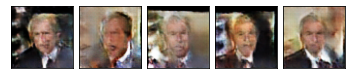

--- EPOCH 89/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.09it/s]
Discriminator loss: 0.1884475466707405
Generator loss:     8.177658467922571


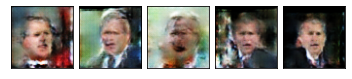

--- EPOCH 90/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.76it/s]
Discriminator loss: 0.1951210996100925
Generator loss:     7.613900445542246


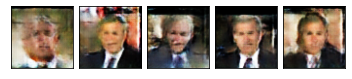

--- EPOCH 91/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.80it/s]
Discriminator loss: 0.11447796028740001
Generator loss:     6.954993747315317


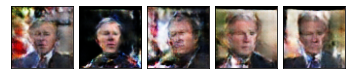

--- EPOCH 92/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.06it/s]
Discriminator loss: 0.09222081286024372
Generator loss:     7.651306336780764


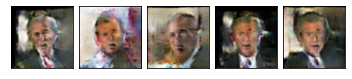

--- EPOCH 93/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.04it/s]
Discriminator loss: 0.30840834627314556
Generator loss:     9.150826926501292


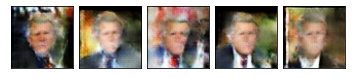

--- EPOCH 94/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.17it/s]
Discriminator loss: 0.32622875814449115
Generator loss:     8.039713558161035


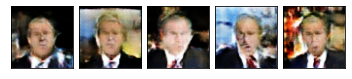

--- EPOCH 95/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.81it/s]
Discriminator loss: 0.27645951375927563
Generator loss:     7.440830712048513


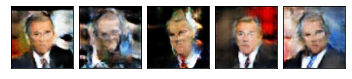

--- EPOCH 96/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.20it/s]
Discriminator loss: 0.1569155094407077
Generator loss:     6.288607961726639


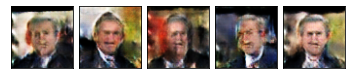

--- EPOCH 97/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.12it/s]
Discriminator loss: 0.10224257112603705
Generator loss:     6.9465977605783715


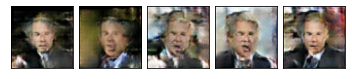

--- EPOCH 98/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.04it/s]
Discriminator loss: 0.19371677722500744
Generator loss:     8.035671430938649


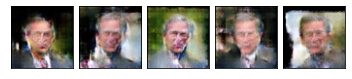

--- EPOCH 99/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.24it/s]
Discriminator loss: 0.2228558979278325
Generator loss:     8.295279759281087


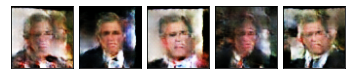

--- EPOCH 100/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.25it/s]
Discriminator loss: 0.11383471611606062
Generator loss:     7.195943746926649


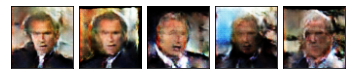

In [149]:
import IPython.display
import tqdm
from hw4.gan import train_batch, save_checkpoint

num_epochs = 100  

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

In [ ]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [ ]:
from cs3600.answers import display_answer
import hw4.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(hw4.answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(hw4.answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(hw4.answers.part3_q3)